In [1]:
from sklearn.linear_model import RidgeClassifier

from utils import ImageDataset

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn

from sklearn import metrics
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50, efficientnet_b0
from torchvision.transforms.v2 import Compose, RandomHorizontalFlip, RandomResizedCrop, RandomRotation, RandomVerticalFlip, ToDtype, ToImage
from tqdm.notebook import tqdm
from umap import UMAP

In [6]:
BATCH_SIZE = 16
METADATA_PATH = 'Data/metadata_BR00116991.csv'
IMAGE_DIR = 'Data/downsampled_data'
rng = torch.manual_seed(77)

transforms = Compose([
    ToImage(),
    RandomResizedCrop(128),
    ToDtype(torch.float32, scale=True),
])

dataset = ImageDataset(image_dir=IMAGE_DIR, metadata_path=METADATA_PATH, transforms=transforms, convert_rgb=True)
device = torch.device('mps')
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2], generator=rng)
train_loader, test_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12), DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)

In [3]:
def extract_features(device, dataloader, classifier):
    features = []
    labels = []
    classifier.eval()
    with torch.no_grad():
        for images, label in tqdm(dataloader):
            embeddings = classifier(images.to(device))
            embeddings = embeddings.view(embeddings.size(0), -1)
            
            features.append(embeddings.cpu())
            labels.extend(label)

    return torch.cat(features, dim=0).cpu(), torch.Tensor(labels).unsqueeze(1).cpu()

In [4]:
def train_loop(device, classifier, train_loader, optimizer, scheduler, loss_fn, n_epochs):
    losses, accs = [], []
    classifier.train()
    for epoch in range(1, 1+n_epochs):
        loss_val = 0
        acc_val = 0
        n = 0
        for (X, y) in tqdm(train_loader):
            m = y.size(0)
    
            X, y = X.to(device), y.to(device)
            yhat = classifier(X)
            pred = torch.argmax(yhat, dim=1)
            
            loss = loss_fn(yhat, y)
            acc = (pred == y).sum()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_val += loss.item() * m
            acc_val += acc.item()
            n += m
        
        print(f'Epoch {epoch}: Loss = {loss_val / n:.3f}; Accuracy = {acc_val / n:.3f}')
        losses.append(loss_val / n)
        accs.append(acc_val / n)
        
        scheduler.step()
    
    return np.array(losses), np.array(accs)
        

In [ ]:
clf = nn.Sequential(*list(resnet50(num_classes=dataset.n_classes()).children()))

optim = torch.optim.Adam(clf.parameters(), 0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

losses, accs = train_loop(device, clf, train_loader, optim, scheduler, loss_fn, 20)

  0%|          | 0/144 [00:00<?, ?it/s]

# Old

In [58]:
res = efficientnet_b0().to(device)
encoder = nn.Sequential(*list(res.children())[:-1])

In [59]:
features, labels = extract_features(device, train_loader, encoder)

# torch.save(features, 'features_resnet_50.pt')
# torch.save(labels, 'labels_resnet_50.pt')

  0%|          | 0/144 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 2.93 GB, other allocations: 2.24 GB, max allowed: 6.77 GB). Tried to allocate 1.67 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

<Axes: >

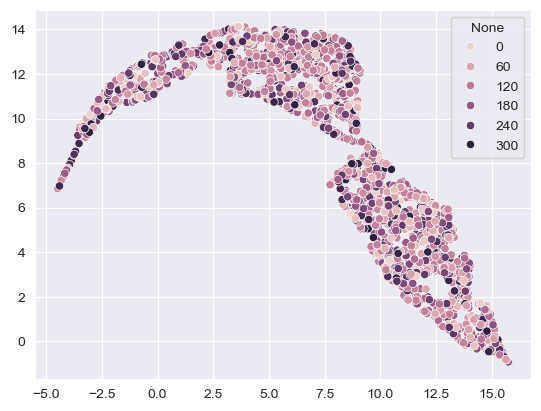

In [8]:
umap = UMAP()
umap_embed = umap.fit_transform(features)
sns.scatterplot(x=umap_embed[:,0], y=umap_embed[:,1], hue=labels.flatten())

<Axes: >

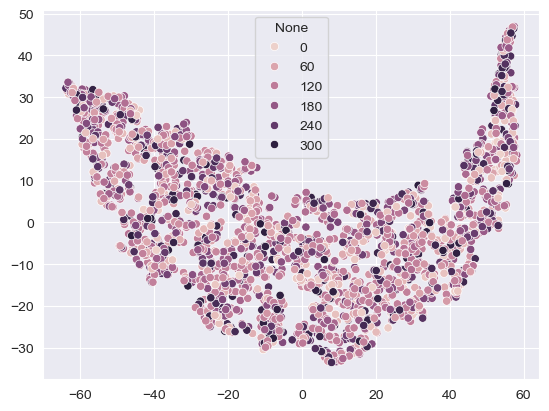

In [9]:
tsne = TSNE()
tsne_embed = tsne.fit_transform(features)

sns.scatterplot(x=tsne_embed[:,0], y=tsne_embed[:,1], hue=labels.flatten())

In [8]:
test_features, test_labels = extract_features(device, train_loader, encoder)

# torch.save(test_features, 'test_features_resnet_50.pt')
# torch.save(test_labels, 'test_labels_resnet_50.pt')

  0%|          | 0/144 [00:00<?, ?it/s]

In [28]:
features, labels = torch.load('features_efficientnet_b0.pt'), torch.load('labels_efficientnet_b0.pt')
test_features, test_labels = torch.load('test_features_efficientnet_b0.pt'), torch.load('test_labels_efficientnet_b0.pt')

In [51]:
clf = RidgeClassifier(alpha=0.05)
clf = clf.fit(features, labels.flatten())

/opt/miniconda3/envs/stat4243/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.69615e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [52]:
print(metrics.accuracy_score(labels.flatten(), clf.predict(features)))
print(metrics.accuracy_score(test_labels.flatten(), clf.predict(test_features)))

0.8247602441150829
0.28378378378378377


In [114]:
# torch.save(test_features, 'test_features.pt')
# torch.save(test_labels, 'test_labels.pt')

<Axes: >

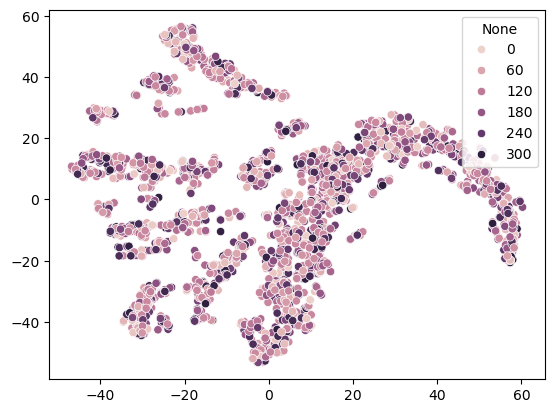

In [116]:
tsne = TSNE()
tsne_embed = tsne.fit_transform(features)

sns.scatterplot(x=tsne_embed[:,0], y=tsne_embed[:,1], hue=labels.flatten())